In [9]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from models import graph_classifier, gnn_models
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from loader import hetero_graph_loader 
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.transforms import Compose, RemoveIsolatedNodes

from utils import prep
from explainability import grad_cam
from graph_plotting import graph_2D


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

data_type = "DCP"
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}
label_names = ["Healthy/DM", "PDR", "NPDR"]


vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"


#train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
#                                                        void_graph_path,
#                                                        hetero_edges_path,
#                                                        mode = "train",
#                                                        label_file = label_file, 
#                                                        line_graph_1 =True, 
#                                                        class_dict = octa_dr_dict)



test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "debug",
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)


In [11]:
# remove isolated nodes
#for data in train_dataset:
#    RemoveIsolatedNodes()(data) 

for data in test_dataset:
    RemoveIsolatedNodes()(data) 


In [12]:
# prepare data
#prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)
node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(test_dataset)
prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)

In [13]:
ids  = list(test_dataset.hetero_graphs.keys())
labels = [data.y[0].cpu().detach().item() for data in test_dataset.hetero_graphs.values()]

In [28]:
# print the number of learnables parameters in the model "model"
print(f"Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Number of learnable parameters: 120131


[0]
[0]
0011_OD


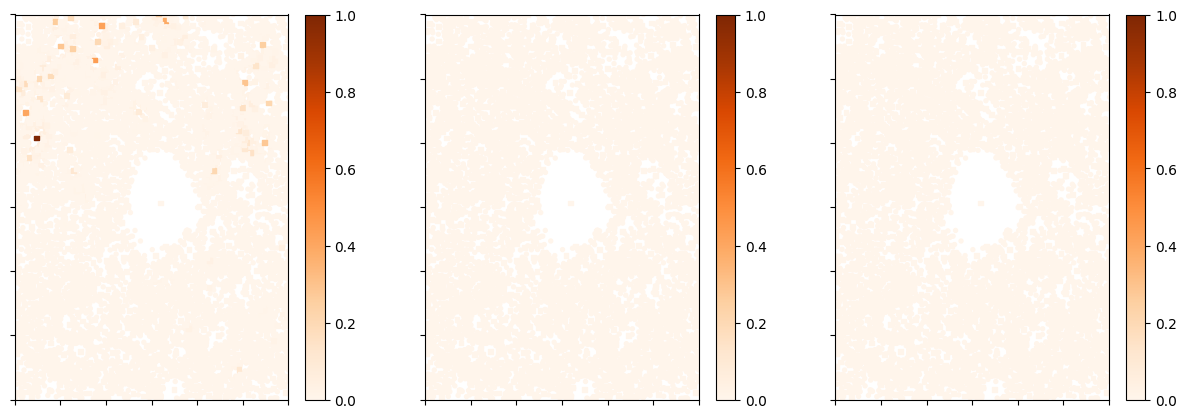

[0]
[0]
0035_OS


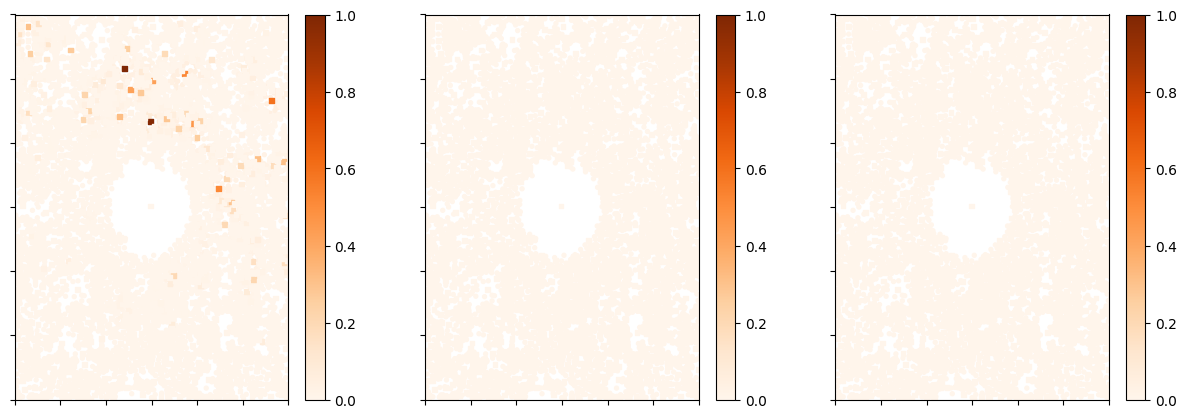

[0]
[0]


KeyboardInterrupt: 

In [36]:
node_types = ["graph_1", "graph_2"]
# create the gnn hetero model
#model = gnn_models.HeteroGNN(hidden_channels = 64, 
#                              out_channels= 3, 
#                              num_layers= 3, 
#                              dropout = 0, 
#                              aggregation_mode= global_mean_pool,
#                              node_types = node_types,
#                              )

model = gnn_models.HeteroGNN(hidden_channels = 64, 
                              out_channels= 3, 
                              num_layers= 3, 
                              dropout = 0, 
                              aggregation_mode= global_max_pool,
                              node_types = node_types,
                              )
#load the pretrained weights from the checkpoint "model_global_mean_pool.pt"
state_dict = torch.load("model_global_max_pool_best.pt")

#print(state_dict)
model.load_state_dict(state_dict)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset.to(device), batch_size = 1, shuffle=False) # 

loss = torch.nn.CrossEntropyLoss()

i = 0
stp = 20
model.to(device)
for data in test_loader:
    model.eval()
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.batch_dict, data._slice_dict, training = True)
    y_t = data.y.cpu().detach().numpy()
    y_pred = out.cpu().detach().numpy().argmax(axis=1)
    print(y_t)
    print(y_pred)
    #print(accuracy_score(y_t, y_pred))
    #print(balanced_accuracy_score(y_t, y_pred))

    cam_cls = [0,1,2]
    cam = grad_cam.grad_cam_data(model, data, cam_cls, scale = True)

    #print(max_val, min_val)
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    print(ids[i])
    for ax_idx, cam_cls in enumerate(cam):
        plotter2d = graph_2D.HeteroGraphPlotter2D()
        plotter2d.set_val_range(1, 0)
        plotter2d.plot_graph_2D(test_dataset[i],edges= False, pred_val_dict=cam_cls, ax = ax[ax_idx])


    plt.show()
    i += 1
    if i >= stp:
        break


In [56]:
model.eval()
output = model(data.x_dict, data.edge_index_dict, data.batch_dict, data._slice_dict, training = True)
output[:, 2].backward(retain_graph=True)

out1 = model.final_conv_grads_1

In [53]:
output[:, 1].backward(retain_graph=True)